# post-processing

Scratch code to post-process `analysis.py` log files.

**TODO:**
#- full MC simulation with 30+ trials and 3-8 agents
- full MC simulation with 50+ trials and 10-15 agents for each of three dynamics model
- Negar feedback
- WRITE PAPER
- move to hardware

In [1]:
from itertools import cycle

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import seaborn as sns

import decentralized as dec

In [2]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.util

In [3]:
%matplotlib ipympl
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

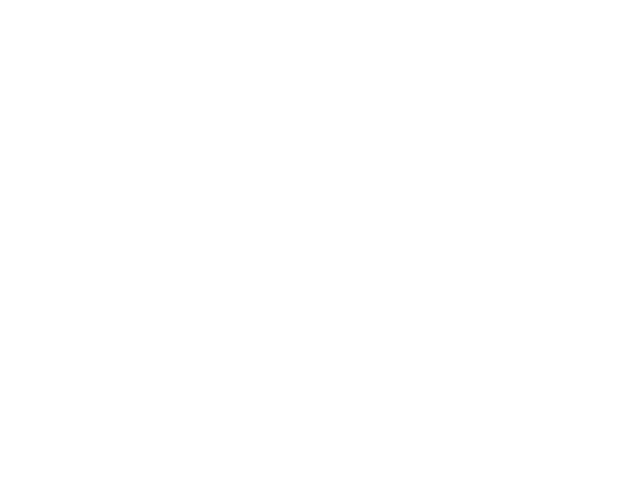

In [4]:
fig = plt.figure()

In [6]:
# filename = dec.repopath / "logs" / "dec-mc-1_08-04-22_22.55.01.csv"
filename = dec.repopath / "logs" / "dec-mc-3_08-22-22_08:17.csv"
df = pd.read_csv(filename)

# Turn string lists into more usable objects.
df.loc[:, 'ids'] = df.loc[:, 'ids'].apply(eval)
df.loc[:, 'times'] = df.loc[:, 'times'].apply(lambda e: np.array(eval(e)))
df.loc[:, 'subgraphs'] = df.loc[:, 'subgraphs'].apply(eval)
df.loc[:, 'dist_left'] = df.loc[:, 'dist_left'].apply(eval)
# df.loc[:, 'sizes'] = df.loc[:, 'subgraphs'].apply(lambda s: [len(si) for si in s])

# Add a few additional statistitics.
df.loc[:, 'avgtimes'] = df.loc[:, 'times'].apply(np.mean)
df.loc[:, 'avgdist'] = df.loc[:, 'dist_left'].apply(np.mean)
# df.loc[:, 'avgsizes'] = df.loc[:, 'sizes'].apply(np.mean)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Randy666/Documents/projects/ICON_lab/decentralized/logs/dec-mc-3_08-22-22_08:17.csv'

In [ ]:
def group_metric(frame, metric):
    """Get a metric and organize by n_agents then centralized"""
    
    grouped = []
    n_agents_iter = frame.loc[:, 'n_agents'].unique()
    for n_agents in n_agents_iter:
        frame_i = frame.loc[frame.n_agents == n_agents]
        metric_cen = frame_i.loc[frame_i.centralized == True, metric]
        metric_dec = frame_i.loc[frame_i.centralized == False, metric]
        grouped.extend([
            np.vstack(metric_cen).flatten(), np.vstack(metric_dec).flatten()
        ])
        
    return grouped

def group_convergence(frame):
    """Grouping to compute convergence rates"""
    
    grouped = []
    n_agents_iter = frame.loc[:, 'n_agents'].unique()
    for n_agents in n_agents_iter:
        frame_i = frame.loc[frame.n_agents == n_agents]
        
        frame_cen = frame_i.loc[frame_i.centralized == True]
        frame_dec = frame_i.loc[frame_i.centralized == False]
        
        grouped.extend([
            frame_cen.converged.sum() / frame_cen.converged.size,
            frame_dec.converged.sum() / frame_dec.converged.size
        ])
        
    return grouped

In [ ]:
def plot_metric_by_model(df, grouped_metric, kind="box", ylabel=None):
    """Visualize the metric across dynamical models"""
    
    if kind not in {"box", "violin"}:
        raise ValueError()
    
    models = df.dynamics.unique().tolist()
    n_agents_iter = df.n_agents.unique().tolist()
    
    plt.clf()
    colors = cycle(("C3", "C0"))

    for i, (model, metric) in enumerate(zip(models, grouped_metric)):
        ax = fig.add_subplot(3, 1, i+1)
        df_model = df[df.dynamics == model]

        n_agents_iter = df_model.n_agents.unique().tolist()
        positions = np.repeat(n_agents_iter, 2) + np.tile([-1, 1], len(n_agents_iter)) / 5
        ticker = plt.LinearLocator(len(n_agents_iter))
        tick_locs = ticker.tick_values(n_agents_iter[0], n_agents_iter[-1])
        
        if kind == "box":
            bp = ax.boxplot(metric, positions=positions, sym="kx", patch_artist=True, showfliers=False, widths=0.35)
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            ax.legend(ax.patches[:2], ["Centralized", "Decentralized"], loc="upper right")
        else:
            vp = ax.violinplot(metric, positions=positions, showmeans=True, showextrema=True)
            for pc, color in zip(vp['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_edgecolor(color)

            for line in vp.values():
                if not isinstance(line, LineCollection):
                    continue
                line.set_colors("black")
                line.set_alpha(0.7)
            ax.legend(["Centralized", "Decentralized"])

        ax.set_xticks(tick_locs, labels=n_agents_iter)
        ax.set_title(model)
        ax.set_xlabel("# Agents")
        if ylabel:
            ax.set_ylabel(ylabel)

    plt.draw()
    

In [ ]:
def plot_convergence_by_model(df, conv_rates):
    """Visualize the metric across dynamical models"""
    
    models = df.dynamics.unique().tolist()
    n_agents_iter = df.n_agents.unique().tolist()
    
    plt.clf()
    colors = ("C3", "C0")

    for i, (model, metric) in enumerate(zip(models, conv_rates)):
        ax = fig.add_subplot(3, 1, i+1)
        df_model = df[df.dynamics == model]

        n_agents_iter = df_model.n_agents.unique().tolist()
        positions = np.repeat(n_agents_iter, 2) + np.tile([-1, 1], len(n_agents_iter)) / 5
        ticker = plt.LinearLocator(len(n_agents_iter))
        tick_locs = ticker.tick_values(n_agents_iter[0], n_agents_iter[-1])
        
        ax.bar(positions, metric, color=colors*len(n_agents_iter), width=0.4)
        ax.legend(ax.patches[:2], ["Centralized", "Decentralized"])
        ax.set_xticks(tick_locs, labels=n_agents_iter)
        ax.set_title(model)
        ax.set_xlabel("# Agents")
        ax.set_ylabel("Convergence Rate")

    plt.draw()

In [ ]:
models = df.dynamics.unique().tolist()
n_agents_iter = df.n_agents.unique().tolist()

all_times = [group_metric(df[df.dynamics == model], "avgtimes")
             for model in models]
all_dists = [group_metric(df[(df.dynamics == model) & (df.loc[:, 'last'] == True)], "avgdist")
             for model in models]
all_costs = [group_metric(df[(df.dynamics == model) & (df.loc[:, 'last'] == True)], "J")
             for model in models]
all_ts = [group_metric(df[(df.dynamics == model) & (df.loc[:, "last"] == True) & (df.converged == True)], "t") 
          for model in models]

conv_rates = [group_convergence(df[(df.dynamics == model) & (df.loc[:, 'last'] == True)])
              for model in models]

**NOTE:** distance left, final cost, and convergence rates aren't meaningful for analysis 1 with unlimited solve time. Similarly, solve time isn't super meaningful for analysis 2.

In [ ]:
plot_metric_by_model(df, all_times, ylabel="Average Solve Time [s]")
plt.suptitle("Average Solve Time", fontsize=16)
plt.draw()
plt.savefig("avg-solve-time.png")

In [ ]:
plot_metric_by_model(df, all_dists, ylabel="Average Distance Left [m]")
plt.suptitle("Average Distance Left", fontsize=16)
plt.draw()
plt.savefig("avg-dist-left.png")

In [ ]:
plot_metric_by_model(df, all_costs, ylabel="Final Cost")
plt.suptitle("Final Cost", fontsize=16)
plt.draw()
plt.savefig("final-cost.png")

In [ ]:
plot_metric_by_model(df, all_ts, ylabel="Convergence Time [s]")
plt.suptitle("Simulation Convergence Time", fontsize=16)
plt.draw()
plt.savefig("convergence-times.png")

In [ ]:
plot_convergence_by_model(df, conv_rates)
plt.suptitle("Convergence Rates", fontsize=16)
plt.draw()
plt.savefig("convergence-rates.png")

## scratch

In [ ]:
# This would be nice, but unfortunately catplot is a figure-level plot.
double_int = df[df.dynamics == "QuadcopterDynamics6D"]

sns.catplot(data=double_int, x="n_agents", y="avgtimes", hue="centralized", kind="box", legend=False, showfliers=False)
plt.xlabel("# Agents")
plt.ylabel("Averange Solve Time [s]")
plt.title("2D Double Integrator")
ax = plt.gca()
plt.legend([ax.patches[0], ax.patches[2]], ["Decentralized", "Centralized"])
plt.tight_layout()

### potential function minimization

Visualization of minimizing a potential function using stationary obstacles. Any optimal trajectory will try to traverse from its start to its goal with as low of cost as possible. 

In [ ]:
import mpl_toolkits.mplot3d.art3d as art3d

In [ ]:
plt.figure()

In [ ]:
start = np.array([[3, 3]])
end = np.array([[0, 0]])
obstacles = np.array([
    [2, 2], [1, 3], [0.2, 1.1]
])

radii = np.array([0.5, 0.3, 0.6])

In [ ]:
def cost(pos):
    """Reference plus weighted obstacle avoidance cost"""
    ref_cost = np.linalg.norm(pos - end, axis=1)
    obstacle_dists = np.linalg.norm(pos - obstacles, axis=1)
    obstacle_cost = np.sum(np.fmin(np.zeros(1),  obstacle_dists - radii) ** 2)
    return ref_cost + 10*obstacle_cost

In [ ]:
axis = (-1, 4, -1, 4)
sample_grid = np.mgrid[axis[0]:axis[1]:0.1, axis[2]:axis[3]:0.1].T.reshape(-1,2)
costs = np.zeros((0,))
for point in sample_grid:
    costs = np.concatenate([costs, cost(point)])
side_len = round(np.sqrt(sample_grid.shape[0]))
square_costs = costs.reshape(side_len, side_len)

In [ ]:
plt.clf()
fig = plt.gcf()
ax = fig.add_subplot(projection="3d")

X = np.r_[axis[0]:axis[1]:0.1]
Y = np.r_[axis[2]:axis[3]:0.1]
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, square_costs + 2, cmap=plt.cm.plasma)

for obstacle, radius in zip(obstacles, radii):
    p = plt.Circle(obstacle, radius)
    ax.add_patch(p)
    art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
    
pstart = ax.scatter(start[0,0], start[0,1], 0, s=80, c='g', marker='x')
pend = ax.scatter(end[0,0], end[0,1], 0, s=80, c='r', marker='x')

# ax.set_title("Potential Function Minimization")
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 4)
# ax.set_zlim(0, 30)
# fig.legend([p, pstart, pend], ["Obstacles", "Start", "End"], loc="lower right")
fig.colorbar(surf, shrink=0.5, label="Potential Function")
plt.tight_layout()

plt.draw()